In [1]:
import pandas as pd
import numpy as np
import os
from tqdm import tqdm
from matplotlib import pyplot as plt
import seaborn as sns

In [2]:
from helper_functions.clean_transitions import clean_transition_column
from helper_functions.simulate_game import simulate_game

In [3]:
avg_matrix = pd.read_excel('avg_transition_matrix_with_manual_edits.xlsx', sheet_name = 'Mean Pasted', index_col='Starting_State')

In [4]:
# def combine_matrices(matrix_A, matrix_B, avg, params=[]):
#     pass

In [5]:
from scipy.optimize import minimize

In [6]:
def accuracy(simulation_outcome, game_result):
    real_A_score = game_result.iloc[-1]['Home']
    real_B_score = game_result.iloc[-1]['Away']

    sim_A_score=[simulation_outcome[1][x][0] for x in range(len(simulation_outcome[1]))]
    sim_B_score=[simulation_outcome[1][x][1] for x in range(len(simulation_outcome[1]))]
    a_error = (real_A_score-sim_A_score)**2
    b_error = (real_B_score-sim_B_score)**2

    return np.mean(np.sqrt(a_error+b_error))

In [7]:
def accuracy_ou(simulation_outcome, game_result):
    real_A_score = game_result.iloc[-1]['Home']
    real_B_score = game_result.iloc[-1]['Away']

    real_total = real_A_score + real_B_score

    sim_A_score=[simulation_outcome[1][x][0] for x in range(len(simulation_outcome[1]))]
    sim_B_score=[simulation_outcome[1][x][1] for x in range(len(simulation_outcome[1]))]
    sim_total = np.array(list(map(lambda x,y: x+y, sim_B_score, sim_A_score)))


    return np.mean(sim_total-real_total)

In [8]:
def accuracy_winner(simulation_outcome, game_result):
    real_A_score = game_result.iloc[-1]['Home']
    real_B_score = game_result.iloc[-1]['Away']

    team_A_win = real_A_score > real_B_score

    sim_A_score=[simulation_outcome[1][x][0] for x in range(len(simulation_outcome[1]))]
    sim_B_score=[simulation_outcome[1][x][1] for x in range(len(simulation_outcome[1]))]
    sim_win = sim_A_score > sim_B_score


    return team_A_win == sim_win

In [9]:
# abc=simulate_game(combined_matrix,num_games=100)

In [10]:
# #pseudo code
# for game in games:
#     load matrix_A
#     load matrix_B
#     find final score of game
#     run 100 or 1000 simulation of one possible param set
#     calculate accuracy

In [11]:
import time

In [12]:
func_calls = 0
scalar_history = []
acc_history = []

In [13]:
# def callback_function(xk):
#     global func_calls
#     func_calls += 1
#     scalar_history.append(xk.copy()) 
#     print("Iteration:", func_calls, "  x0:", xk)

In [51]:
# Define optimization problem
def optimization_problem(scalar_multiples):
    # global m1, m2, m3, matrix1, matrix2, combined_matrix, checked

    #choose n random games to simulate

    accuracy_list = []
    for g in np.random.choice(os.listdir('raw_game_pulls'),10):
        total_acc=0
        # game_res = pd.read_excel('raw_game_pulls/6195965_Play-By-Play for Indiana vs Army West Point.xlsx')

        #locate teams to find matrices
        game_res = pd.read_excel('raw_game_pulls/{}'.format(g))
        game_strings = g.split(' vs ')
        team_A = game_strings[0].split('for ')[-1]
        team_B = game_strings[1].split('.xlsx')[0]

        matrix1 = pd.read_excel('team_specific_matrix/{}_A.xlsx'.format(team_A), index_col='Starting_State')
        matrix2 = pd.read_excel('team_specific_matrix/{}_B.xlsx'.format(team_B), index_col='Starting_State')


        # Reshape the parameters into matrices
        m1 = scalar_multiples[:18].reshape(-1, 1)
        m2 = scalar_multiples[18:36].reshape(-1, 1)
        m3 = scalar_multiples[36:].reshape(-1, 1)

        # Construct combined matrix
        # combined_matrix = m1 * matrix1 + m2 * matrix2 + m3 * avg_matrix  # Adjust with scalar multiples
        combined_matrix = pd.DataFrame()
        for i in range(18):
            combined_matrix[i] = matrix1.iloc[:, i] * m1[i] + \
                                matrix2.iloc[:, i] * m2[i] + \
                                avg_matrix.iloc[:, i] * m3[i]
            
        combined_matrix.columns=avg_matrix.columns
        
        for r in combined_matrix.index:
            if combined_matrix.loc[r].sum()==0.:
                combined_matrix.loc[r]=avg_matrix.loc[r].copy()
            
        combined_matrix = combined_matrix.div(combined_matrix.sum(axis=1), axis=0)
        combined_matrix.columns=avg_matrix.columns

        # Evaluate performance on X game simulations
        result = simulate_game(combined_matrix, 10)
        total_acc += accuracy(result, game_res)
        accuracy_list.append(accuracy(result, game_res))
    # scalar_history.append(scalar_multiples)
    # acc_history.append(np.mean(total_acc))
    return np.mean(accuracy_list)

In [52]:
# Initialize parameters
# initial_guess = np.random.rand(54)
    
initial_guess=   [1,1,1,1,1,0,0,0,1,0,0,0,0,0,1,1,1,0,
                    0,0,0,0,0,1,1,1,0,1,1,1,1,1,0,0,0,1,
                    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

# Define bounds for parameters (optional)
bounds = [(0, 1)] * 54  # Non-negative scalar multiples

In [53]:
team_A_guess = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
                0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
team_B_guess = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
                0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
avg_guess = [0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
             0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
             1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]
eoo_1 = [1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,
         0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,
         0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]
eoo_2 = [0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,
         1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,1,0,
         0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

mean_teams = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
              1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
              0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

mean_all = [1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
            1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,
            1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]

halves = [1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,
          0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,
          0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0]

In [54]:
# guesses = [initial_guess, team_A_guess, team_B_guess,mean_teams,halves]

In [55]:
# for g in guesses:
#     res = optimization_problem(np.array(g))
#     acc_history.append(res)

In [56]:
#this accuracy came with initial guess, team A only, team B only, mean teams, and mean all.

acc_history = [15.292806853524496,
 15.57244836198554,
 18.087572077402445,
 18.13050025120224,
 19.490909061580126]

In [57]:
g_avg = np.array([0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                     0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,
                     1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1])

In [58]:
g1 = np.array([1,1,1,1,1,0,0,0,1,0,0,0,0,0,1,1,1,0,
    0,0,0,0,0,1,1,1,0,1,1,1,1,1,0,0,0,1,
    0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0])

g2 = (g1 + g_avg)*.5

g3 = g1 * 0.9 + g_avg * .1

g4 = g1 * .8 + g_avg * .1

g5 = g1 * .5 + g_avg * .1

g6 = np.array([1,1,1,1,1, 0, 0, 0,1,0,0,0,0,0,.5,.5,.5,0,
               0,0,0,0,0,.5,.5,.5,0,1,1,1,1,1, 0, 0, 0,1,
               0,0,0,0,0, 0, 0, 0,0,0,0,0,0,0, 0, 0, 0,0])

In [59]:
g7 = np.array([1,1,1,1,1, 0, 0, 0,1,0,0,0,0,0,.2,.2,.2,0,
               0,0,0,0,0,.2,.2,.2,0,1,1,1,1,1, 0, 0, 0,1,
               0,0,0,0,0, 0, 0, 0,0,0,0,0,0,0, 0, 0, 0,0])

g8 = np.array([1,1,1,1,1, 0, 0, 0,1,0,0,0,0,0,.8,.8,.8,0,
               0,0,0,0,0,.8,.8,.8,0,1,1,1,1,1, 0, 0, 0,1,
               0,0,0,0,0, 0, 0, 0,0,0,0,0,0,0, 0, 0, 0,0])

In [63]:
lob = []
acc_history=[]
gsss = [g1,g2,g3,g4,g5,g6,g7,g8,team_A_guess, team_B_guess, avg_guess]
for guess in tqdm(range(len(gsss))):
        for i in range(5):
                res = optimization_problem(np.array(gsss[guess]))
                acc_history.append(res)
                lob.append(guess)

100%|██████████| 3/3 [01:16<00:00, 25.43s/it]


In [68]:
results_plot = pd.DataFrame(zip(lob,acc_history))

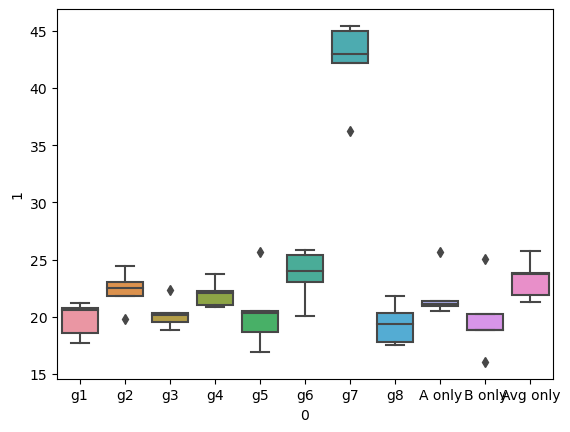

In [70]:
fig,ax=plt.subplots()
sns.boxplot(x=0, y=1, data=results_plot)#, labels = ['g1','g2','g3','g4','g5','g6','g7','g8'])
ax.set_xticklabels(['g1','g2','g3','g4','g5','g6','g7','g8','A only', 'B only', 'Avg only']);

In [ ]:
#pure distance accuracy tests is not yielding promising results.
#other accuracy tests to perform - winner, margin, and O/U total.

In [90]:
# Define optimization problem
def optimization_problem_2(scalar_multiples):
    # global m1, m2, m3, matrix1, matrix2, combined_matrix, checked
    for g in np.random.choice(os.listdir('raw_game_pulls'),100):
        total_acc=0
        # game_res = pd.read_excel('raw_game_pulls/6195965_Play-By-Play for Indiana vs Army West Point.xlsx')
        game_res = pd.read_excel('raw_game_pulls/{}'.format(g))
        game_strings = g.split(' vs ')
        team_A = game_strings[0].split('for ')[-1]
        team_B = game_strings[1].split('.xlsx')[0]

        matrix1 = pd.read_excel('team_specific_matrix/{}_A.xlsx'.format(team_A), index_col='Starting_State')
        matrix2 = pd.read_excel('team_specific_matrix/{}_B.xlsx'.format(team_B), index_col='Starting_State')


        # Reshape the parameters into matrices
        m1 = scalar_multiples[:18].reshape(-1, 1)
        m2 = scalar_multiples[18:36].reshape(-1, 1)
        m3 = scalar_multiples[36:].reshape(-1, 1)

        # Construct combined matrix
        # combined_matrix = m1 * matrix1 + m2 * matrix2 + m3 * avg_matrix  # Adjust with scalar multiples
        combined_matrix = pd.DataFrame()
        for i in range(18):
            combined_matrix[i] = matrix1.iloc[:, i] * m1[i] + \
                                matrix2.iloc[:, i] * m2[i] + \
                                avg_matrix.iloc[:, i] * m3[i]
            
        combined_matrix.columns=avg_matrix.columns
        
            
        
            
            #this is constantly failing. Instead, I am just going to force all matrices
            #to have the same lines for Af3 and Bf3
        for r in combined_matrix.index:
            if combined_matrix.loc[r].sum()==0.:
                combined_matrix.loc[r]=avg_matrix.loc[r].copy()
            
        combined_matrix = combined_matrix.div(combined_matrix.sum(axis=1), axis=0)
        combined_matrix.columns=avg_matrix.columns

        # Evaluate performance
        result = simulate_game(combined_matrix, 1)
        total_acc += accuracy_ou(result, game_res)
    # scalar_history.append(scalar_multiples)
    # acc_history.append(np.mean(total_acc))
    return np.mean(total_acc)

In [91]:
lob_2 = []
gsss = [g1,g2,g3,g4,g5,g6,g7,g8]
acc_history_2 = []
for guess in tqdm(range(len(gsss))):
        for i in range(10):
                res = optimization_problem_2(gsss[guess])
                acc_history_2.append(res)
                lob_2.append(guess)

 12%|█▎        | 1/8 [02:01<14:10, 121.47s/it]Exception ignored in: <function ZipFile.__del__ at 0x0000022949E1CC10>
Traceback (most recent call last):
  File "c:\Users\mdona\anaconda3\lib\zipfile.py", line 1816, in __del__
    self.close()
KeyboardInterrupt: 
